In [1]:
import pandas as pd

# Load arguments file
args_df = pd.read_csv("argumentstest.tsv", sep='\t')

# Load labels file
labels_df = pd.read_csv("labelstest.tsv", sep='\t')

print("Arguments shape:", args_df.shape)
print("Labels shape:", labels_df.shape)

Arguments shape: (1576, 4)
Labels shape: (1576, 21)


In [2]:
merged_df = pd.merge(args_df, labels_df, on='Argument ID')
print("Merged shape:", merged_df.shape)

Merged shape: (1576, 24)
Columns: Index(['Argument ID', 'Conclusion', 'Stance', 'Premise',
       'Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity'],
      dtype='object')


In [3]:
merged_df['text'] = merged_df['Conclusion'] + " " + merged_df['Stance'] + " " + merged_df['Premise']
print(merged_df[['text']].head())

                                                text
0  We should end affirmative action against affir...
1  We should end affirmative action in favor of a...
2  We should ban naturopathy in favor of naturopa...
3  We should prohibit women in combat in favor of...
4  We should ban naturopathy in favor of once era...


In [4]:
text_cols = ['Argument ID', 'Conclusion', 'Stance', 'Premise', 'text']
label_columns = [col for col in merged_df.columns if col not in text_cols]
print("Label columns detected:", label_columns)

Label columns detected: ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']


In [6]:
merged_df.to_csv("final_data_with_labels.csv", index=False)

In [7]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the combined text column
encoded_inputs = tokenizer(
    merged_df['text'].tolist(),   # list of texts
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'  # PyTorch tensors
)

In [8]:
print(encoded_inputs.keys())  # To see what keys are returned (usually 'input_ids', 'attention_mask', maybe 'token_type_ids')

print(encoded_inputs['input_ids'].shape)  # Shape of token IDs tensor, e.g., (number_of_samples, max_length)

KeysView({'input_ids': tensor([[ 101, 2057, 2323,  ...,    0,    0,    0],
        [ 101, 2057, 2323,  ...,    0,    0,    0],
        [ 101, 2057, 2323,  ...,    0,    0,    0],
        ...,
        [ 101, 2057, 2323,  ...,    0,    0,    0],
        [ 101, 2057, 2323,  ...,    0,    0,    0],
        [ 101, 2057, 2323,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})
torch.Size([1576, 189])


In [9]:
import torch

# Extract label values as float tensors (required for BCEWithLogitsLoss)
labels = torch.tensor(merged_df[label_columns].values).float()

print("Labels tensor shape:", labels.shape)

Labels tensor shape: torch.Size([1576, 20])


In [10]:
import torch

# Extract label values as float tensors (required for BCEWithLogitsLoss)
labels = torch.tensor(merged_df[label_columns].values).float()

print("Labels tensor shape:", labels.shape)

Labels tensor shape: torch.Size([1576, 20])


In [11]:
from torch.utils.data import Dataset, DataLoader

class HumanValuesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get all encoding inputs for the index idx (input_ids, attention_mask, etc.)
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create dataset
dataset = HumanValuesDataset(encoded_inputs, labels)

# Split into train and validation (80-20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:
# Check dataset size and sample item
print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

# Optional: check one batch of input
batch = next(iter(train_loader))
print("Keys in one batch:", batch.keys())
print("Shape of input_ids:", batch['input_ids'].shape)
print("Shape of labels:", batch['labels'].shape)

Dataset size: 1576
Train size: 1260
Validation size: 316
Keys in one batch: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Shape of input_ids: torch.Size([8, 189])
Shape of labels: torch.Size([8, 20])


In [13]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, get_scheduler
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define number of labels (20 human values)
num_labels = len(label_columns)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type='multi_label_classification'
)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()

# Training parameters
epochs = 3

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"\nEpoch {epoch+1}/{epochs}")
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} finished. Avg Loss: {total_loss / len(train_loader):.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Epoch 1: 100%|██████████| 158/158 [37:22<00:00, 14.19s/it, loss=0.336]


Epoch 1 finished. Avg Loss: 0.4321

Epoch 2/3


Epoch 2: 100%|██████████| 158/158 [32:51<00:00, 12.48s/it, loss=0.341]


Epoch 2 finished. Avg Loss: 0.3541

Epoch 3/3


Epoch 3: 100%|██████████| 158/158 [32:31<00:00, 12.35s/it, loss=0.257]

Epoch 3 finished. Avg Loss: 0.3195


In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

# No gradient needed during evaluation
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)

        # Convert probabilities to binary predictions (threshold = 0.5)
        preds = (probs > 0.5).int()

        all_preds.append(preds)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to numpy for sklearn
y_pred = all_preds.cpu().numpy()
y_true = all_labels.cpu().numpy()

# Compute scores
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.7143
Recall:    0.2456
F1 Score:  0.3655


In [15]:
print("Prediction shape:", y_pred.shape)
print("True label shape:", y_true.shape)

Prediction shape: (316, 20)
True label shape: (316, 20)


Argument ID                   0
Conclusion                    0
Stance                        0
Premise                       0
Self-direction: thought       0
Self-direction: action        0
Stimulation                   0
Hedonism                      0
Achievement                   0
Power: dominance              0
Power: resources              0
Face                          0
Security: personal            0
Security: societal            0
Tradition                     0
Conformity: rules             0
Conformity: interpersonal     0
Humility                      0
Benevolence: caring           0
Benevolence: dependability    0
Universalism: concern         0
Universalism: nature          0
Universalism: tolerance       0
Universalism: objectivity     0
text                          0
dtype: int64
Duplicate Argument IDs: 0


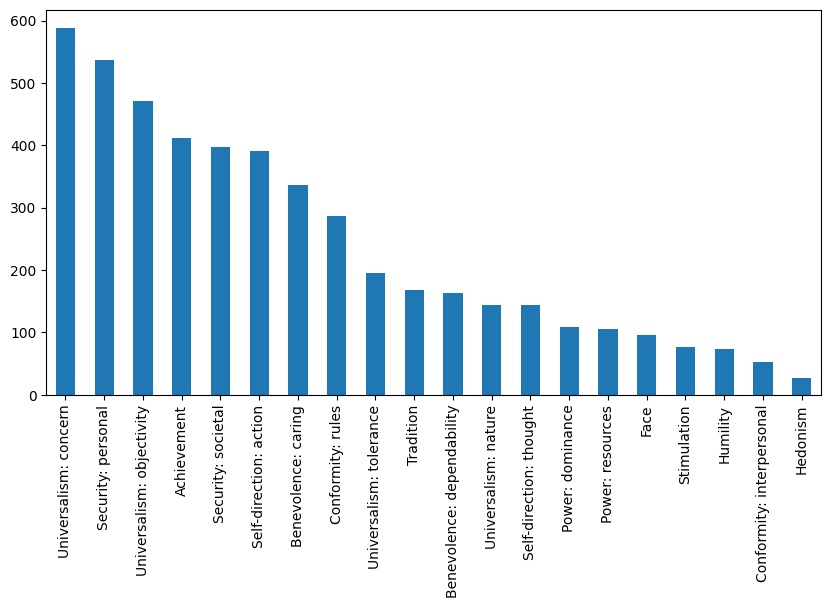

In [16]:
# Check label distribution
label_cols = labels_df.columns.difference(['Argument ID'])
merged_df[label_cols].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

# Check for missing values
print(merged_df.isnull().sum())

# Check for duplicate Argument IDs
print("Duplicate Argument IDs:", merged_df['Argument ID'].duplicated().sum())

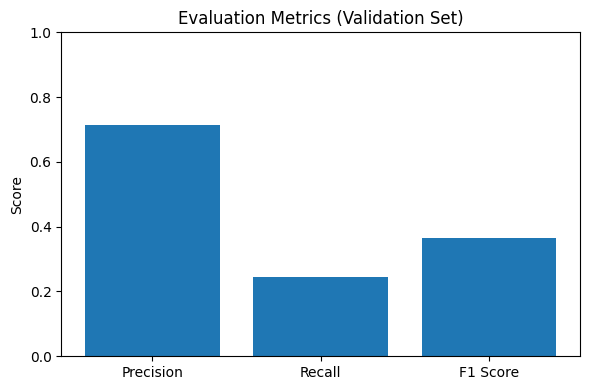

In [17]:
import matplotlib.pyplot as plt

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title("Evaluation Metrics (Validation Set)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

y_pred = all_preds.cpu().numpy()
y_true = all_labels.cpu().numpy()

# ⬇️ These variables are what you need for the chart
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.7143
Recall:    0.2456
F1 Score:  0.3655


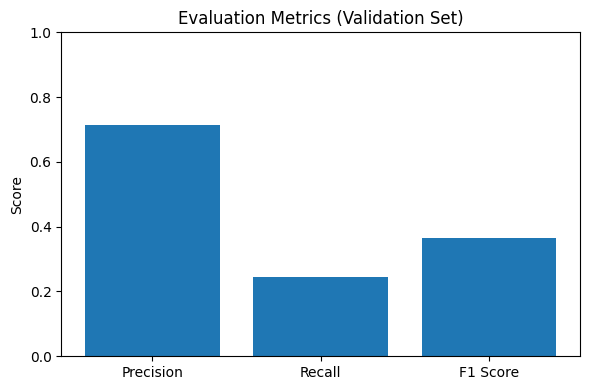

In [19]:
import matplotlib.pyplot as plt

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title("Evaluation Metrics (Validation Set)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

y_pred = all_preds.cpu().numpy()
y_true = all_labels.cpu().numpy()

precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.7143
Recall:    0.2456
F1 Score:  0.3655
